# hdf5

In [12]:
import h5py
import numpy as np
import pandas as pd


In [13]:
#Los Archivos hdf5 funcionan como diccionario y se pueden ispeccionar con keys
h5_vel = h5py.File("../data/c_1/geo_velocity.h5")
h5_vel.keys()

<KeysViewHDF5 ['velocity', 'velocityStd']>

In [14]:
h5_vel["velocity"]

<HDF5 dataset "velocity": shape (1327, 1069), type "<f4">

In [15]:
#Los atributos contienen metadatos
h5_vel["velocity"].attrs.keys()

<KeysViewHDF5 []>

In [16]:
h5_vel.attrs.keys()

<KeysViewHDF5 ['ALOOKS', 'ANTENNA_SIDE', 'AZIMUTH_PIXEL_SIZE', 'BANDS', 'CENTER_INCIDENCE_ANGLE', 'CENTER_LINE_UTC', 'DATA_TYPE', 'DATE12', 'EARTH_RADIUS', 'END_DATE', 'FILE_LENGTH', 'FILE_PATH', 'FILE_TYPE', 'HEADING', 'HEIGHT', 'INTERLEAVE', 'ISCE_VERSION', 'LAT_REF1', 'LAT_REF2', 'LAT_REF3', 'LAT_REF4', 'LENGTH', 'LON_REF1', 'LON_REF2', 'LON_REF3', 'LON_REF4', 'NCORRLOOKS', 'OG_FILE_PATH', 'ORBIT_DIRECTION', 'PLATFORM', 'POLARIZATION', 'PRF', 'PROCESSOR', 'PROJECT_NAME', 'P_BASELINE_BOTTOM_HDR', 'P_BASELINE_TOP_HDR', 'RANGE_PIXEL_SIZE', 'REF_DATE', 'REF_LAT', 'REF_LON', 'REF_X', 'REF_Y', 'RLOOKS', 'STARTING_RANGE', 'START_DATE', 'UNIT', 'WAVELENGTH', 'WIDTH', 'X_FIRST', 'X_STEP', 'X_UNIT', 'Y_FIRST', 'Y_STEP', 'Y_UNIT', 'access_mode', 'altitude', 'azimuthPixelSize', 'azimuthResolution', 'beam_mode', 'beam_swath', 'byte_order', 'data_type', 'earthRadius', 'family', 'file_name', 'firstFrameNumber', 'first_frame', 'image_type', 'lastFrameNumber', 'last_frame', 'length', 'mintpy.compute

In [17]:
h5_coh = h5py.File("../data/c_1/geo_temporalCoherence.h5")

Convertimos los archivos hdf5 a objetos numpy

In [18]:
vel = np.asarray(h5_vel["velocity"])
vel = np.where(np.isnan(vel), 0, vel)

coh = np.asarray(h5_coh['temporalCoherence'])
coh = np.where(np.isnan(coh), 0, coh)

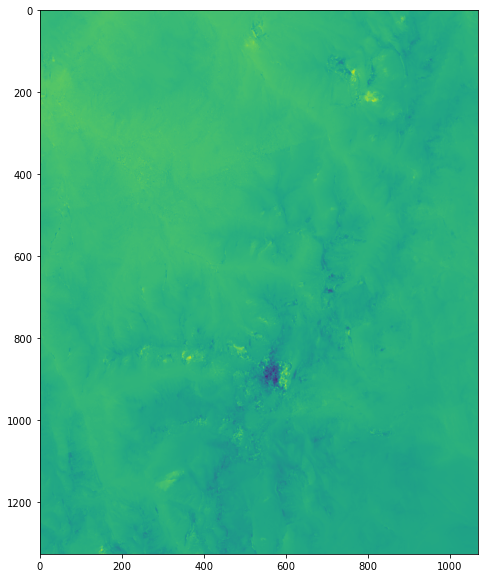

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(vel)

Ojo que en esta escala no se diferencian los valores negativos de los positivos

# Georreferencia

Cada medición (c_1, c_2, c_3) tiene su respectivo `extent`, que contiene las coordenadas de las esquinas de la matriz, necesarias para relacionarla con los polígonos

In [9]:

extent = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_1/extent.tsv", sep="\t", header=None).to_numpy()

In [10]:
extent

array([[-28.11996841, -28.52018356],
       [-69.82037354, -69.42983246]])

Tamaño (en coordenadas) del área

In [21]:
extent[0,0] - extent[0,1]

0.4002151489257777

In [22]:
extent[1,1] - extent[1,0]

0.39054107666015625

# Detección de polígonos

Esta función permite detectar los puntos que están dentro de un polígono mediante triangulación, para lo cual se crea una función para detectar los puntos que están en un triángulo

In [24]:
#Función que detecta cuando un punto o puntos están en un triángulo.
def in_triangle(points, triangle):
    t1, t2, t3 = triangle
    p = points.reshape(-1, 2)
    ret = []
    
    #Tomar 2 pares de vértices (ta, tb) y ver si point y el otro vértice tr están al mismo lado de la recta que forma ta, tb
    for ta, tb, tr in [(t1, t2, t3), (t1, t3, t2), (t2, t3, t1)]:
        ortog = (tb-ta) @ np.array([[0, -1], [1, 0]])
        ret.append(((tr - 0.5*(ta+tb)) @ ortog) * ((points - 0.5*(ta+tb)) @ ortog) >= 0)
    return np.all(ret, axis=0)

#Toma 3 puntos secuenciales y mediante producto punto evalúa el ángulo de giro (con signo) entre el vector p2-p1 y p3-p2
def turn(triang):
    v1 = triang[1]-triang[0]
    v2 = triang[2]-triang[1]
    ang = np.arccos(v1@v2/(np.linalg.norm(v1)*np.linalg.norm(v2)))/(2*np.pi)
    sign = v1[0]*v2[1] - v1[1]*v2[0]
    return ang*sign/abs(sign)

#Método de triangulación para determinar si un punto o puntos están en el polígono
def in_polygon(points, polygon, verbose=False):
    #Order representa los puntos que actualmente están en el polígono, los cuales se irán descartando en un proceso iterativo
    order = list(range(len(polygon)))
    
    #La suma de los ángulos de giro de todo polígono sin intersecciones es 2pi o -2pi. Lo calculamos para detectar concavidad
    angle = sum(turn(polygon[(order*2)[t: t+3]]) for t in range(len(order)))
    ret = []
    while len(order)>= 3:
        print(f"Computando triángulo {len(polygon)-len(order)+1} de {len(polygon)-2}") if verbose else None
        nowlen=len(order) #Para evitar loops infinitos, se arroja un error cuando no se descarta un punto en un ciclo
        
        for t in range(len(order)):
            #En un ciclo se evalúan todos los triángulos formados por 3 vértices consecutivos
            tri = polygon[(order*2)[t: t+3]]
            
            #El triángulo es válido si el ángulo de giro es del mismo signo que el del polígono y si no contiene otros vértices
            if turn(tri)*angle > 0 and np.sum(in_triangle(polygon[(2*order)[t+3:t+len(order)]], tri))==0:
                #Se evalúan los puntos si pertenecen al triángulo, se descarta el vértice central y se repite el ciclo
                ret.append(in_triangle(points, tri))
                order.remove((2*order)[t+1])
                break
        if len(order)==nowlen: 
            print(polygon[order])
            raise Exception("Error en el ciclo!")
    
    #Puntos que pertenecen a cualquiera de los triángulos son considerados dentro del polígono
    return np.any(ret, 0)
            

Probamos la función con un polígono custom y datos random

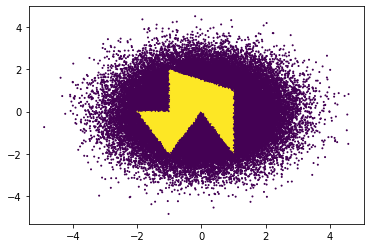

In [25]:
np.random.seed(1991)
points = np.random.randn(100000, 2)*1.1

intriangles = in_polygon(points, np.array([[1,1], [-1,2], [-1,0], [-2,0], [-1,-2], [0,0], [1,-2]]))

plt.scatter(points[:,0], points[:,1], c = intriangles, s=1)

# Glaciares

Cargamos los glaciares mediante pandas. Estos son pares de coordenadas donde el último punto está repetido (cerrado). lo eliminamos y damos vuelta las coordenadas (de formato x,y a formato filas, columnas)

In [26]:
import pandas as pd
glaciar_1 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/glaciares/glaciar_1_strict.tsv", sep="\t", header=None).to_numpy()[:-1]
glaciar_2 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/glaciares/glaciar_2_strict.tsv", sep="\t", header=None).to_numpy()[:-1]
glaciar_3 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/glaciares/glaciar_3_strict.tsv", sep="\t", header=None).to_numpy()[:-1]

glaciar_1 = glaciar_1[:,[1,0]]
glaciar_2 = glaciar_2[:,[1,0]]
glaciar_3 = glaciar_3[:,[1,0]]

La función matrix_polygon permite asignar un extent a un shape de una matriz para luego mediante la función de triangulación de un polígono detectar cuales casillas están dentro del polígono. La probamos con datos dummy y un polígono dummy

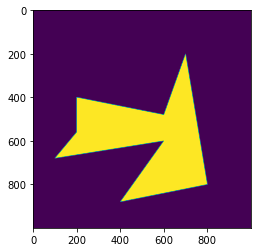

In [27]:
def matrix_polygon(shape, extent, polygon, verbose=False, lower_up=False):
    #Normalizo minmax para evitar en lo posible errores numéricos cuando los triángulos tienen formas muy bizarras
    mean, var = np.mean(extent, axis=1), 100/(extent[:, 1]- extent[:, 0])
    extent, polygon = (var*(np.array(extent).T-mean)).T, var*(np.array(polygon)-mean)
    
    row_vals = np.linspace(extent[0][0], extent[0][1], shape[0], endpoint=False)
    col_vals = np.linspace(extent[1][0], extent[1][1], shape[1], endpoint=False)
    meshx, meshy = np.meshgrid(col_vals, row_vals)
    points = np.array((meshy.flatten(), meshx.flatten())).T
    points += 0.5 * np.array([(extent[0][1]-extent[0][0])/shape[0], (extent[1][1]-extent[1][0])/shape[1]])
    matrix = in_polygon(points, polygon, verbose=verbose)
    return matrix.reshape(shape)

matrix = matrix_polygon(shape = (1000, 1000), extent =np.array([[50, 75], [-20,-15]]), polygon = np.array([[60,-19], 
                                [62,-17], [55, -16.5], [70,-16], [72, -18], [65,-17], [67, -19.5], [64, -19]]))

plt.imshow(matrix)

Utilizamos nuestra función con el shape de la matriz de velocidad y los polígonos de los glaciares. Como son tantos datos, utilizamos verbose.

In [28]:
en_glaciar_1 = matrix_polygon(vel.shape, extent, glaciar_1, verbose=True)

Computando triángulo 1 de 17
Computando triángulo 2 de 17
Computando triángulo 3 de 17
Computando triángulo 4 de 17
Computando triángulo 5 de 17
Computando triángulo 6 de 17
Computando triángulo 7 de 17
Computando triángulo 8 de 17
Computando triángulo 9 de 17
Computando triángulo 10 de 17
Computando triángulo 11 de 17
Computando triángulo 12 de 17
Computando triángulo 13 de 17
Computando triángulo 14 de 17
Computando triángulo 15 de 17
Computando triángulo 16 de 17
Computando triángulo 17 de 17


In [29]:
en_glaciar_2 = matrix_polygon(vel.shape, extent, glaciar_2, verbose=True)

Computando triángulo 1 de 26
Computando triángulo 2 de 26
Computando triángulo 3 de 26
Computando triángulo 4 de 26
Computando triángulo 5 de 26
Computando triángulo 6 de 26
Computando triángulo 7 de 26
Computando triángulo 8 de 26
Computando triángulo 9 de 26
Computando triángulo 10 de 26
Computando triángulo 11 de 26
Computando triángulo 12 de 26
Computando triángulo 13 de 26
Computando triángulo 14 de 26
Computando triángulo 15 de 26
Computando triángulo 16 de 26
Computando triángulo 17 de 26
Computando triángulo 18 de 26
Computando triángulo 19 de 26
Computando triángulo 20 de 26
Computando triángulo 21 de 26
Computando triángulo 22 de 26
Computando triángulo 23 de 26
Computando triángulo 24 de 26
Computando triángulo 25 de 26
Computando triángulo 26 de 26


In [30]:
en_glaciar_3 = matrix_polygon(vel.shape, extent, glaciar_3, verbose=True)

Computando triángulo 1 de 25
Computando triángulo 2 de 25
Computando triángulo 3 de 25
Computando triángulo 4 de 25
Computando triángulo 5 de 25
Computando triángulo 6 de 25
Computando triángulo 7 de 25
Computando triángulo 8 de 25
Computando triángulo 9 de 25
Computando triángulo 10 de 25
Computando triángulo 11 de 25
Computando triángulo 12 de 25
Computando triángulo 13 de 25
Computando triángulo 14 de 25
Computando triángulo 15 de 25
Computando triángulo 16 de 25
Computando triángulo 17 de 25
Computando triángulo 18 de 25
Computando triángulo 19 de 25
Computando triángulo 20 de 25
Computando triángulo 21 de 25
Computando triángulo 22 de 25
Computando triángulo 23 de 25
Computando triángulo 24 de 25
Computando triángulo 25 de 25


Luego fusionamos las 3 matrices para obtener una sóla matriz que es True para las casillas que están dentro de cualquiera de los 3 glaciares

In [31]:
en_glaciar = np.any((en_glaciar_1, en_glaciar_2, en_glaciar_3), axis=0)

# Visualización

Primero, crearemos nuestros colormaps para ver los datos de forma más adecuada. alpha y glow son colormaps transparentes para poder ver más de una matriz en el mismo imshow. Fluor es una matriz divergente (Como "PiYG") para destacar valores negativos y positivos.

In [32]:
from matplotlib.colors import LinearSegmentedColormap

colors = np.column_stack((np.ones((256, 3)), np.linspace(0, 1, 256)))
alpha = LinearSegmentedColormap.from_list(name = "alpha", colors=colors)
glow = LinearSegmentedColormap.from_list(name = "glow", colors=colors*np.array([0.97, 0.58, 0.2, 1]))

colors2 = np.array([[0, .95, 1,1], [0,0,0,1], [.75,.9,0,1]])
fluor = LinearSegmentedColormap.from_list(name = "fluor", colors=colors2)

La función "draw maps" automatiza todas las transformaciones tediosas de coordenadas para permitir visualizar en el mismo imshow tanto polígonos como matrices, con diferentes cmaps. Con subset se puede hacer zoom y con center_scale se puede fijar que el centro del colormap sea en 0

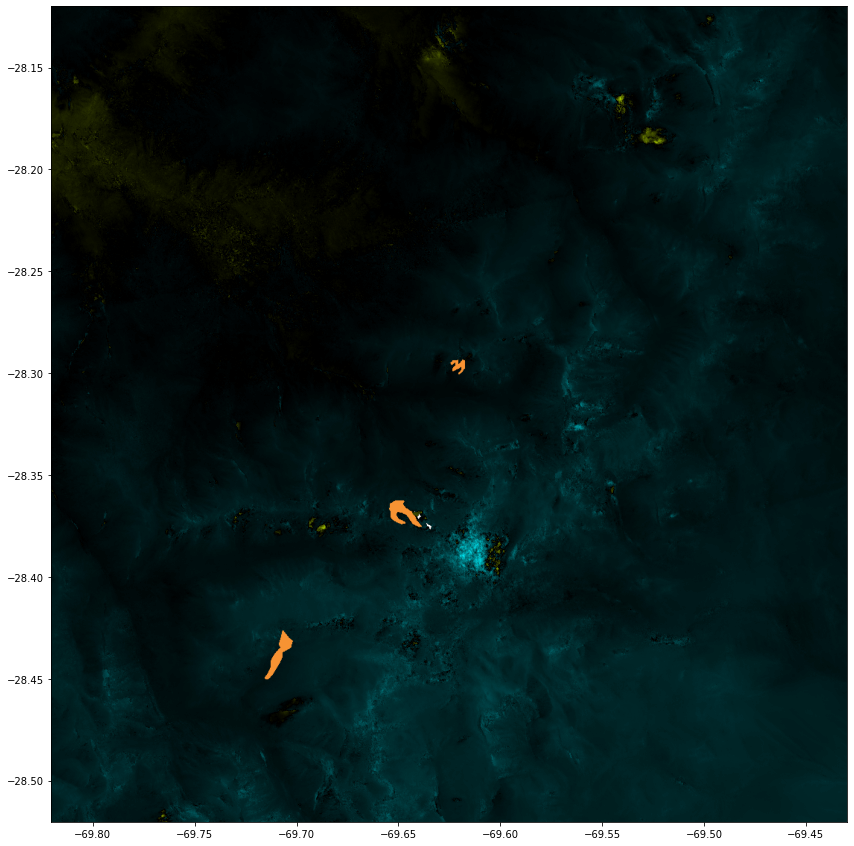

In [36]:
def draw_maps(extent, maps=[], glaciares=[], cmaps="viridis", linewidth=1.5, linecol="white", figsize=(15, 15),
             subset=[[0,1], [0,1]], center_scale = False):
    maps, glaciares, cmaps, center_scale = [v if type(v) == list else [v] for v in [maps, glaciares, cmaps, center_scale]]
    subset = (np.array(maps[0].shape).reshape(-1, 1)*np.array(subset)).astype(int)
    imshow_extent = extent[:,:1]  +  (extent[:,1:]-extent[:,:1]) * subset/np.array(maps[0].shape).reshape(-1, 1)
    imshow_extent = np.concatenate((imshow_extent[1], np.flip(imshow_extent[0])))
    glaciares = [np.concatenate((glaciar, [glaciar[0]])) for glaciar in glaciares]
    plt.figure(figsize=figsize)
    for i, mp in enumerate(maps):
        img = mp[subset[0][0]:subset[0][1], subset[1][0]:subset[1][1]]
        if center_scale[i % len(center_scale)]:
            img = np.where(img>0, img/np.max(img), -img/np.min(img))
        plt.imshow(img, extent = imshow_extent, cmap = cmaps[i % len(cmaps)])
    for glaciar in glaciares:
        plt.plot(glaciar[:,1], glaciar[:,0], color=linecol, linewidth=linewidth)


draw_maps(extent, [vel, en_glaciar, -coh], cmaps=[fluor, glow, alpha], center_scale=[True, False, False])

Lo mismo pero con polígonos

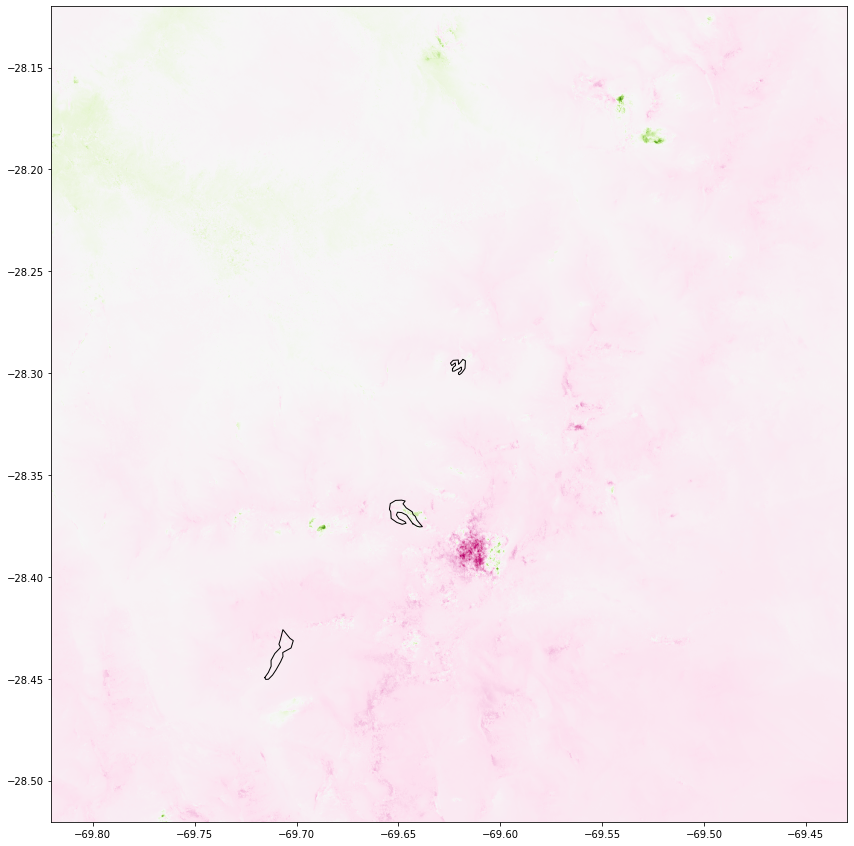

In [37]:
draw_maps(extent, [vel], cmaps=["PiYG", glow], glaciares = [glaciar_1, glaciar_2, glaciar_3],
          center_scale=True, linewidth=1, linecol="black")

Zoom a cada glaciar

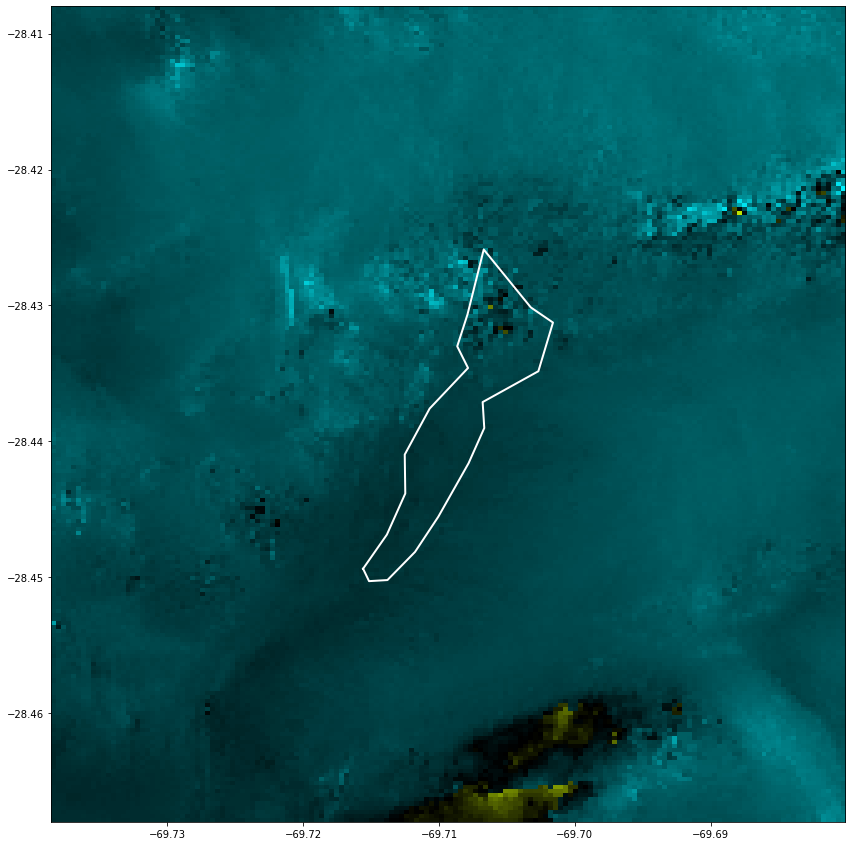

In [38]:
draw_maps(extent, vel, center_scale=True, glaciares = glaciar_1, cmaps=fluor, linewidth=2,
          linecol="white", subset=[[.72, .87], [.21, .36]])

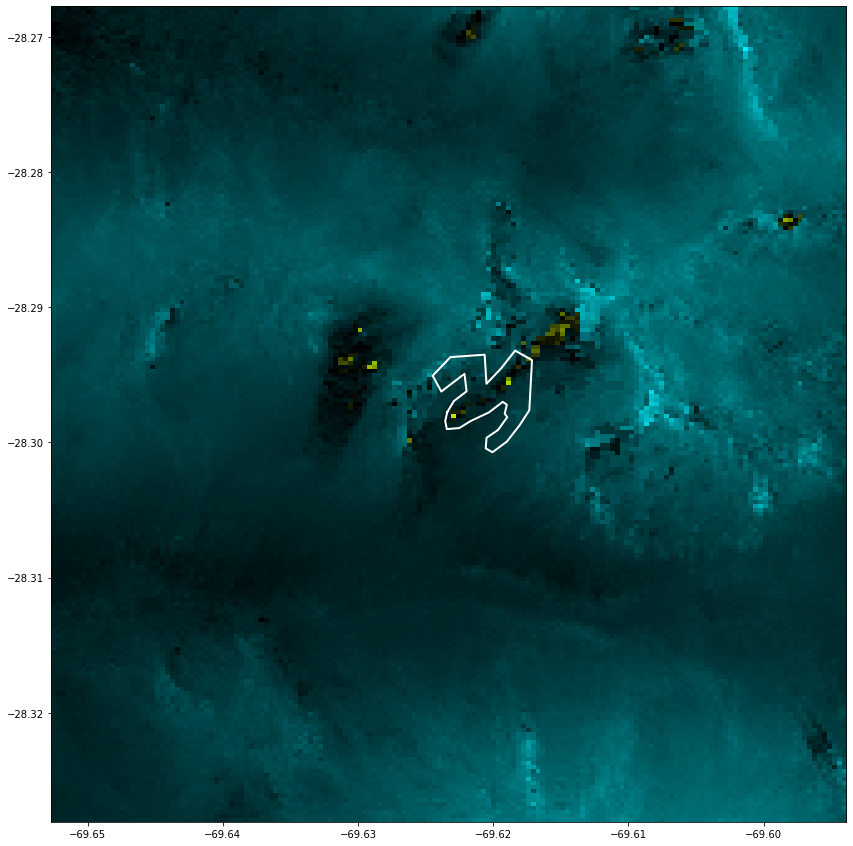

In [43]:
draw_maps(extent, vel, glaciares = glaciar_2, cmaps=fluor, center_scale=True, linewidth=2, 
          linecol="white", subset=[[.37, .52], [.43, .58]])

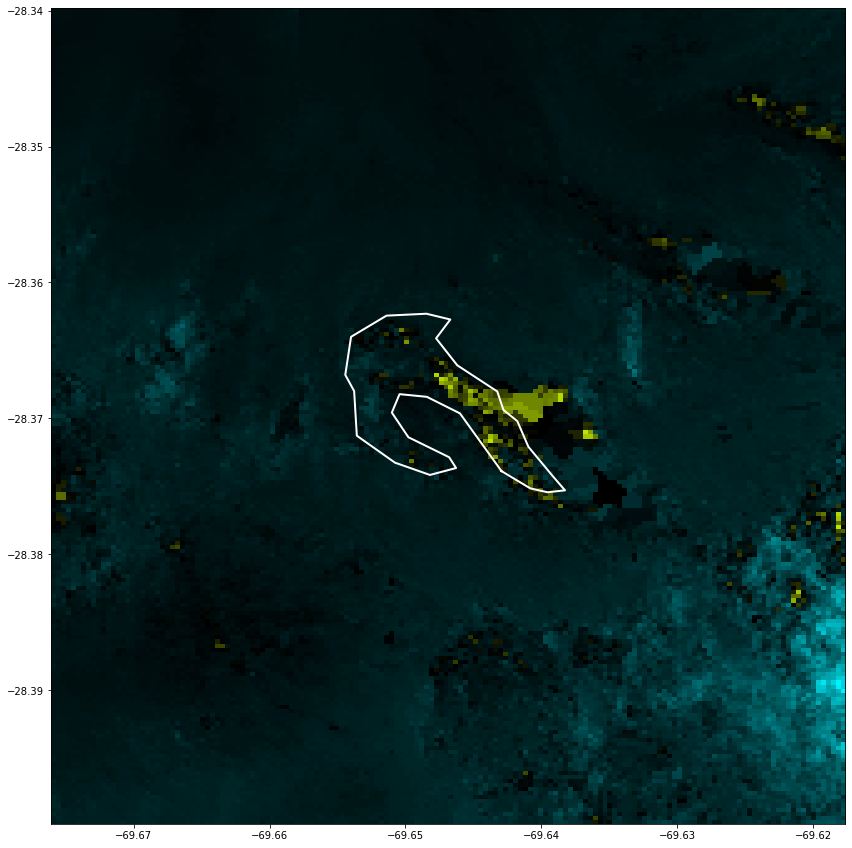

In [44]:
draw_maps(extent, vel, linewidth=2, glaciares = glaciar_3, cmaps=fluor, center_scale=True,
          linecol="white", subset=[[.55, .7], [.37, .52]])

Ver cómo calza el polígono con los pixeles marcados

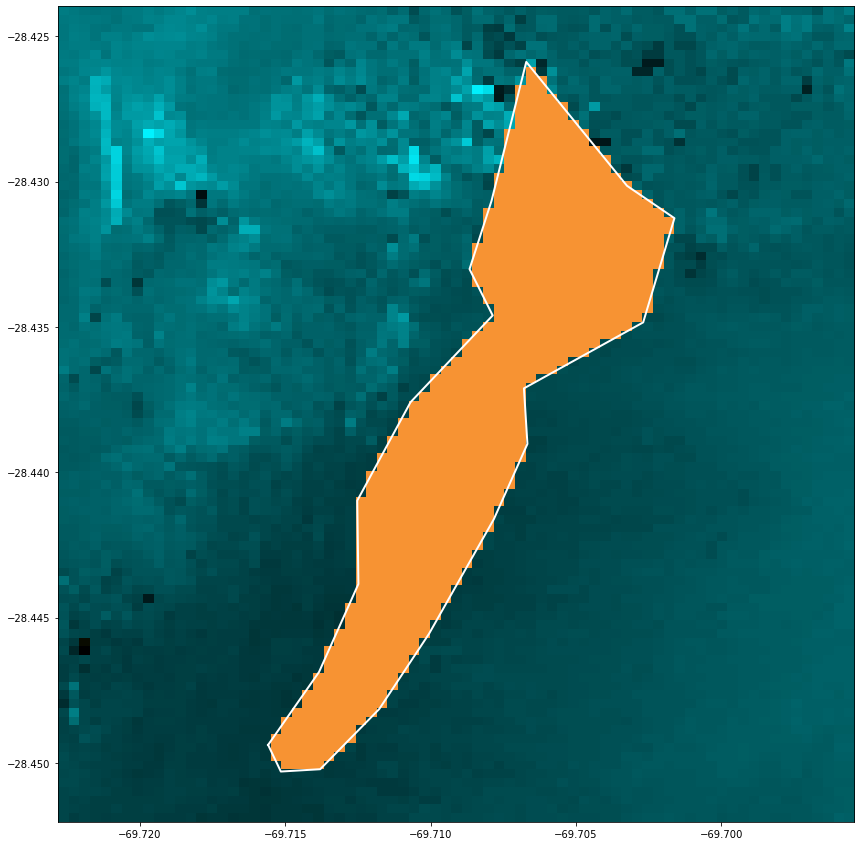

In [52]:
draw_maps(extent, [vel, en_glaciar], center_scale=[True, False], cmaps=[fluor, glow], glaciares = glaciar_1, 
          linewidth=2, subset=[[.76, .83], [.25, .32]])

# EDA

Intento de EDA visualizando correlación local entre pixeles cercanos. Parte no terminada ni comentada

In [40]:
def convolve_correlation(matrix, kernel_size, consider= None):
    kernels, ks = [], kernel_size
    if consider is None:
        consider = np.full(matrix.shape, True)
    for i in range(matrix.shape[0]-ks+1):
        for j in range(matrix.shape[1]-ks+1):
            if consider[i+ks//2, j+ks//2]:
                kernels.append(matrix[i:i+ks, j:j+ks].flatten())
    kernels= np.array(kernels)
    kernels = kernels - np.mean(kernels, axis=0)
    var = np.mean(kernels**2, axis=0)
    var = np.expand_dims(var, axis=0) * np.expand_dims(var, axis=1)
    covs = np.expand_dims(kernels, axis=2) * np.expand_dims(kernels, axis=1)
    cors = np.mean(covs, axis=0) / np.sqrt(var)
    order = [j*ks + ((ks-i-1) if j%2==1 else i) for j in range(ks) for i in range(ks)]
    cors = cors[order]
    return cors[:, order]
    

covs = convolve_correlation(vel,  3)
covs_notgla = convolve_correlation(vel, 3, consider = np.logical_not(en_glaciar))
covs_gla = convolve_correlation(vel, 3, consider= en_glaciar)

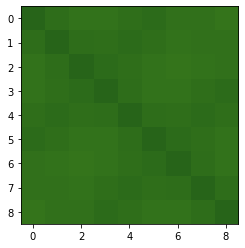

In [41]:
plt.imshow(np.where(covs>0, covs/np.max(covs), -covs/np.min(covs)), cmap="PiYG", vmin=-1, vmax=1)

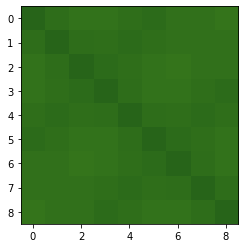

In [42]:
plt.imshow(np.where(covs_notgla>0, covs_notgla/np.max(covs_notgla), -covs_notgla/np.min(covs_notgla)),
           cmap="PiYG", vmin=-1, vmax=1)

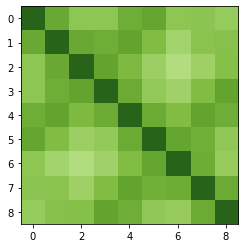

In [43]:
plt.imshow(np.where(covs_gla>0, covs_gla/np.max(covs_gla), -covs_gla/np.min(covs_gla)), cmap="PiYG", vmin=-1, vmax=1)

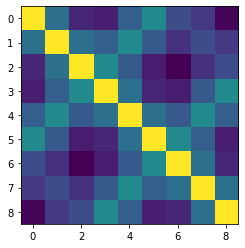

In [44]:
plt.imshow(covs)

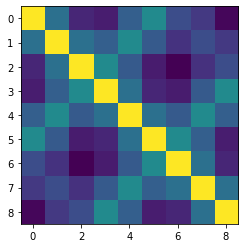

In [45]:
plt.imshow(covs_notgla)

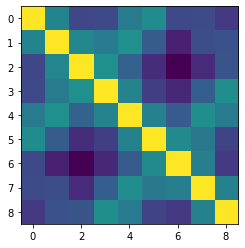

In [46]:
plt.imshow(covs_gla)

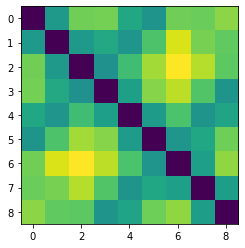

In [47]:
plt.imshow(( covs_notgla-covs))

In [48]:
def avg_pool(matrix):
    boolean = type(matrix[0,0]) == np.bool_
    matrix = matrix*1
    ret = np.zeros(np.array(matrix.shape)//2)
    for i in range(ret.shape[0]):
        for j in range(ret.shape[1]):
            ret[i,j] = np.mean(matrix[2*i:2*i+2, 2*j:2*j+2])
    if boolean:
        ret = ret>0.5
    return ret

vel_l2 = avg_pool(vel)
en_glaciar_l2 = avg_pool(en_glaciar)

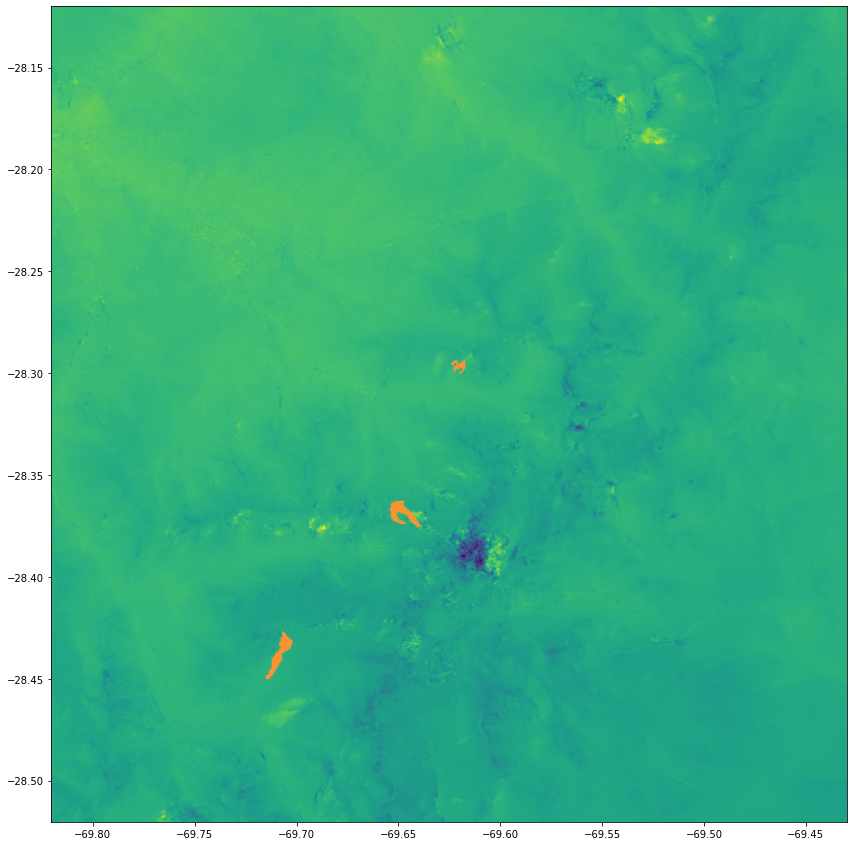

In [49]:
draw_maps(extent, [vel_l2, en_glaciar_l2], cmaps=["viridis", glow])

In [50]:
vel_l3 = avg_pool(vel_l2)
en_glaciar_l3 = avg_pool(en_glaciar_l2)

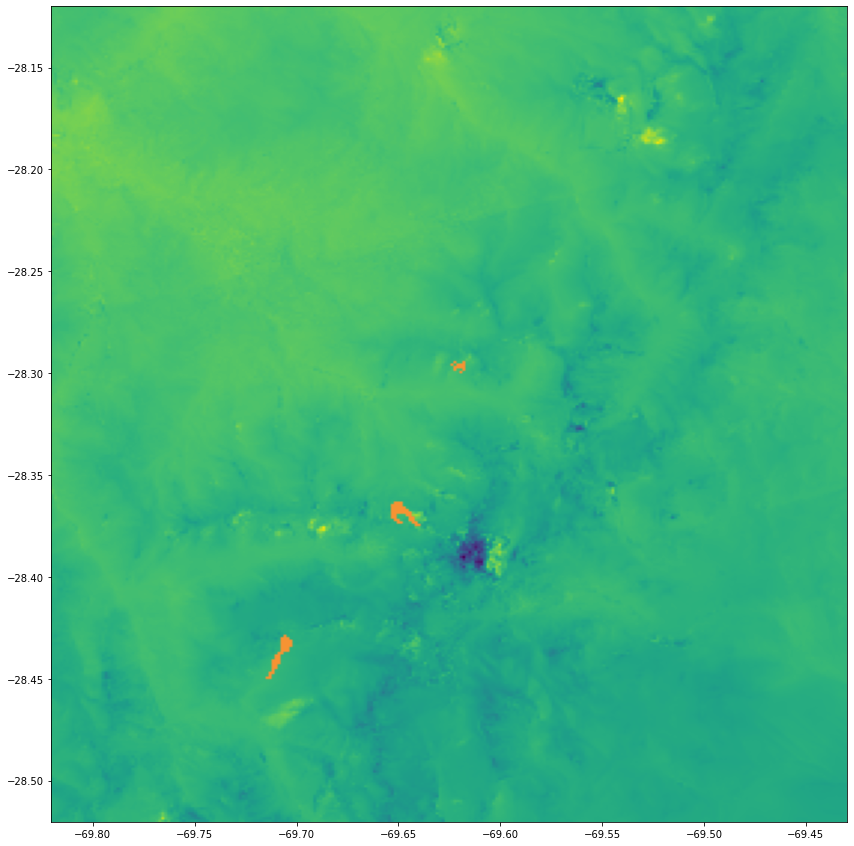

In [51]:
draw_maps(extent, [vel_l3, en_glaciar_l3], cmaps=["viridis", glow])

In [52]:
covs_l2 = convolve_correlation(vel_l2,  3)
covs_notgla_l2 = convolve_correlation(vel_l2, 3, consider = np.logical_not(en_glaciar_l2))
covs_gla_l2 = convolve_correlation(vel_l2, 3, consider= en_glaciar_l2)

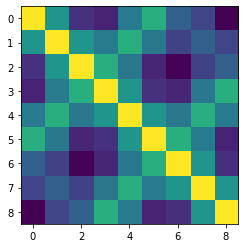

In [53]:
plt.imshow(covs_l2)

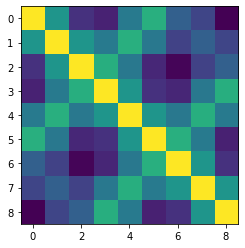

In [54]:
plt.imshow(covs_notgla_l2)

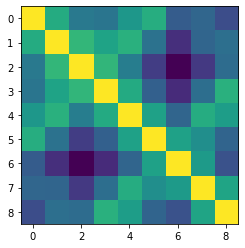

In [55]:
plt.imshow(covs_gla_l2)

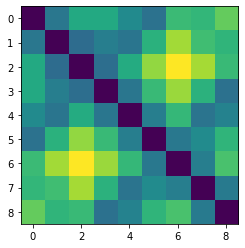

In [56]:
plt.imshow(covs_notgla_l2-covs_l2)

In [57]:
covs_l3 = convolve_correlation(vel_l3,  3)
covs_notgla_l3 = convolve_correlation(vel_l3, 3, consider = np.logical_not(en_glaciar_l3))
covs_gla_l3 = convolve_correlation(vel_l3, 3, consider= en_glaciar_l3)

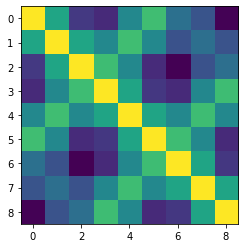

In [58]:
plt.imshow(covs_l3)

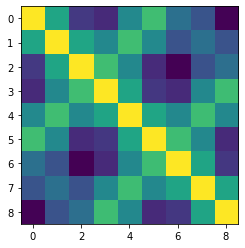

In [59]:
plt.imshow(covs_notgla_l3)

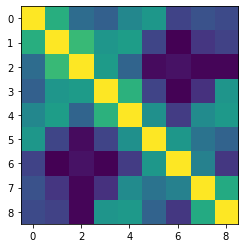

In [60]:
plt.imshow(covs_gla_l3)

In [129]:
def substract_correlation(matrix, shape):
    X, Y = matrix.shape
    I, J = shape
    ret = []
    for i in range(-I, I+1):
        for j in range(-J, J+1):
            ret.append( (matrix[I:-I,J:-J]-matrix[I+i:X-I+i,J+j:Y-J+j]) * matrix[I:-I,J:-J] )
    corrs = np.sum(np.array(ret), axis=0)
    return corrs
    
vel_subc = substract_correlation(vel, (5, 5))

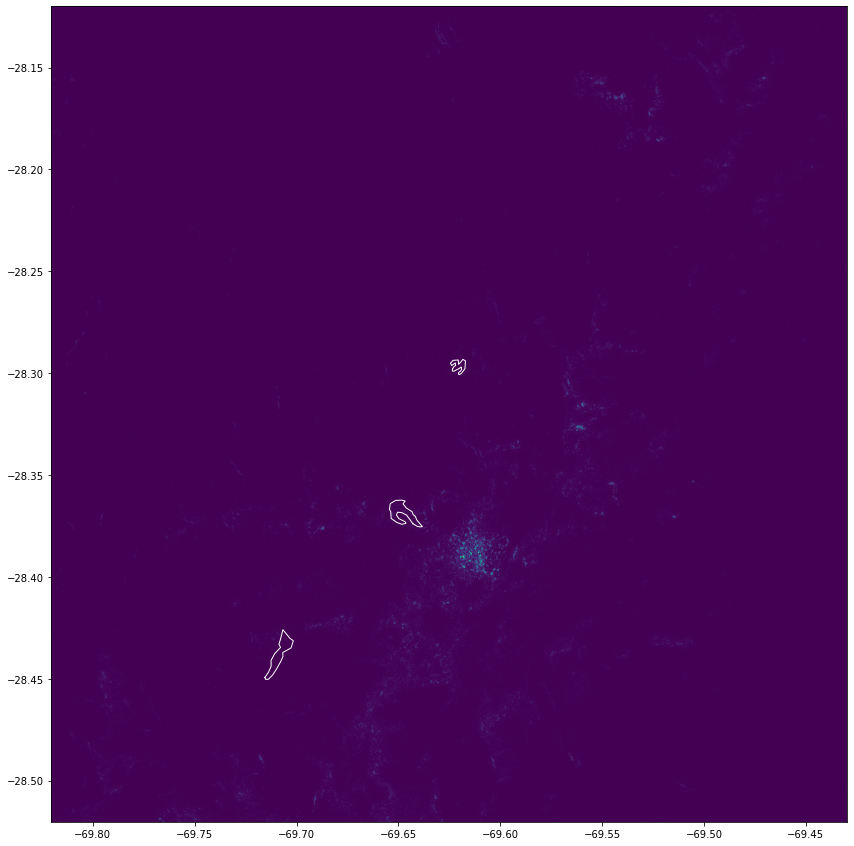

In [133]:
draw_maps(extent, np.abs(vel_subc), glaciares = [glaciar_1, glaciar_2, glaciar_3], linewidth=1)

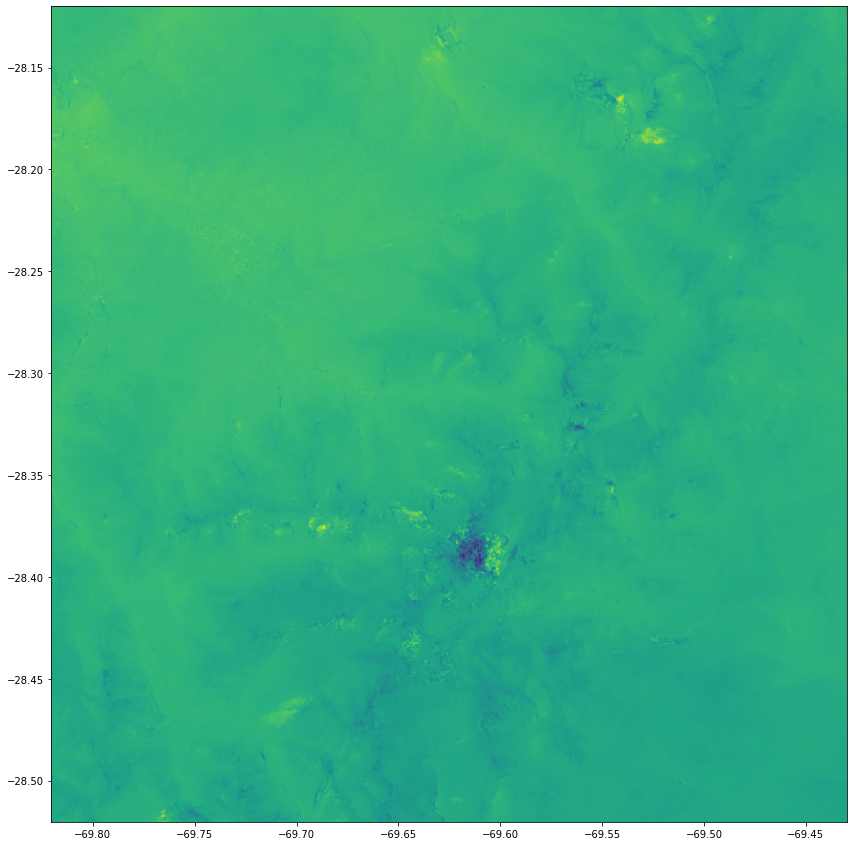

In [134]:
draw_maps(extent, vel)

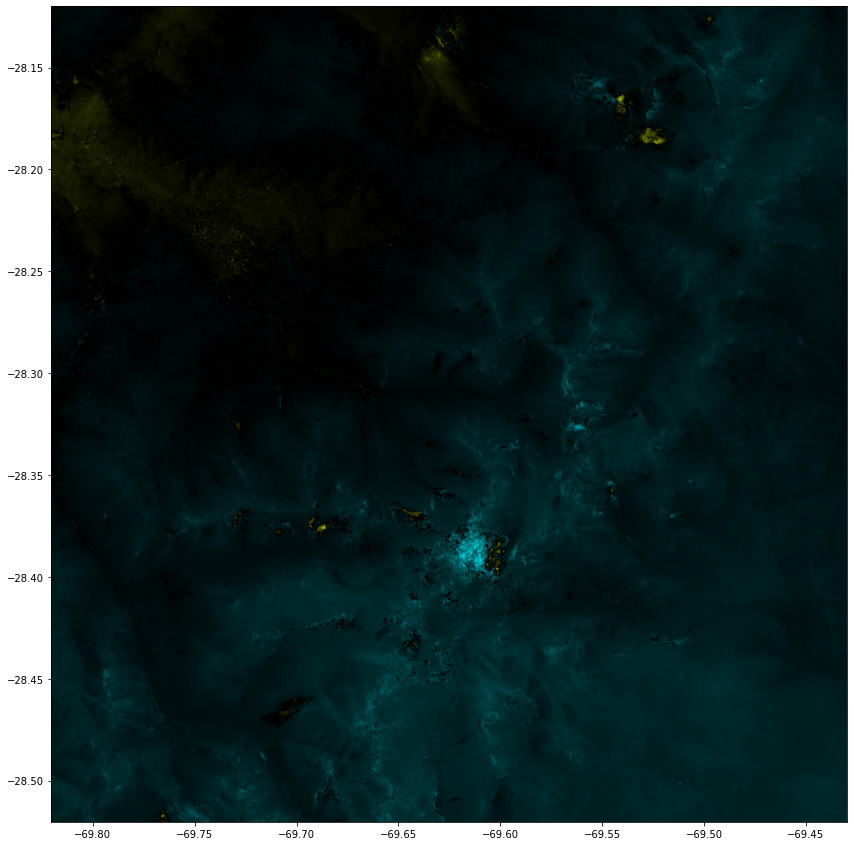

In [54]:

draw_maps(extent, vel, cmaps = fluor, center_scale=True)

In [166]:
def create_colormap(colors, docks, name=""):
    cmap = np.zeros((256, 4))
    points = np.linspace(0, 1, 256)
    colors = np.array(colors)
    for i in range(1, len(colors)):
        condition = np.all((points >= docks[i-1], points<= docks[i]), axis=0)
        cmap[condition] =  colors[i-1] + (points[condition]-docks[i-1]).reshape(-1, 1) * (colors[i]- colors[i-1])
    return LinearSegmentedColormap.from_list(name = name, colors=cmap)

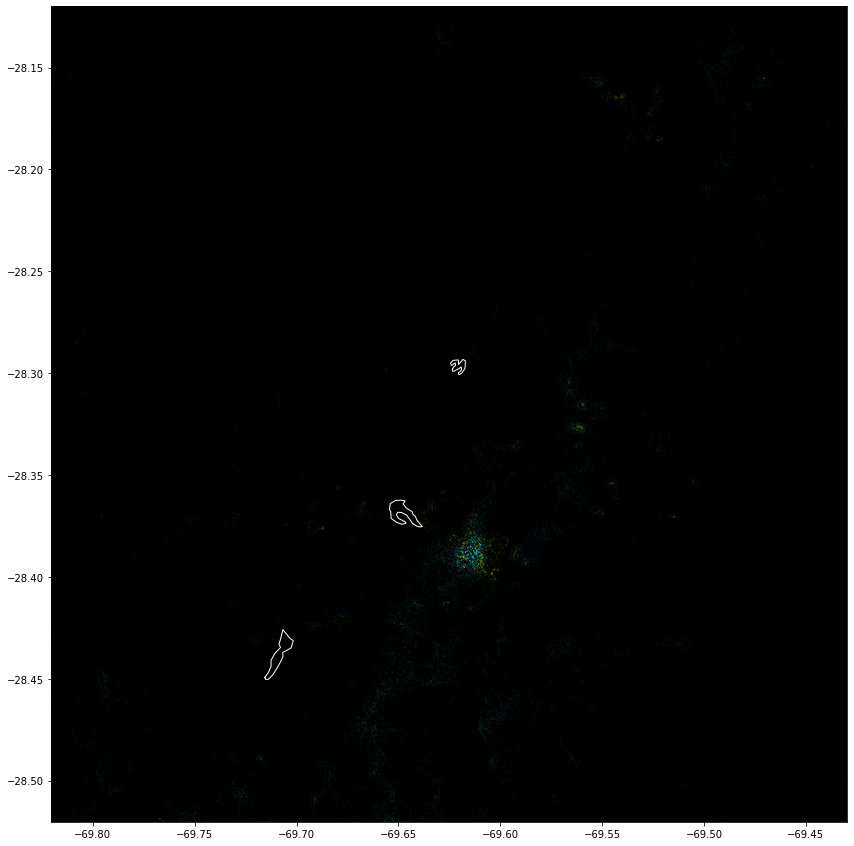

In [224]:
draw_maps(extent, vel_subc, cmaps=fluor, center_scale=True, glaciares = [glaciar_1, glaciar_2, glaciar_3], linewidth=1)

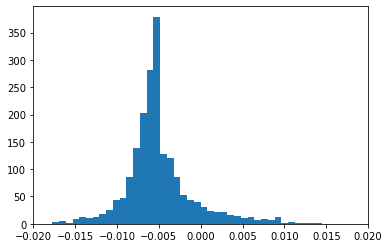

In [241]:
plt.hist(vel.flatten()[en_glaciar.flatten()], bins=40)
plt.xlim([-0.02, 0.02])
plt.show()

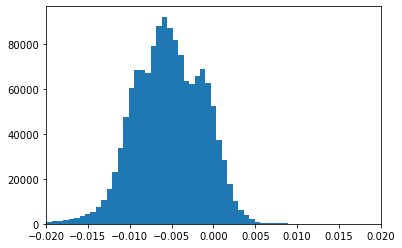

In [244]:
plt.hist(vel.flatten(), bins=150)
plt.xlim([-0.02, 0.02])
plt.show()

In [277]:
def density(X, data, sigma_scale = .1, cap = 10000):
    sigma = np.std(data) * sigma_scale
    data = np.random.choice(data, cap, replace=False) if len(data)>cap else data
    return np.mean(np.exp(-(X - data.reshape(-1, 1))**2 /(2*sigma**2))/(sigma*np.sqrt(2*np.pi)), axis=0)

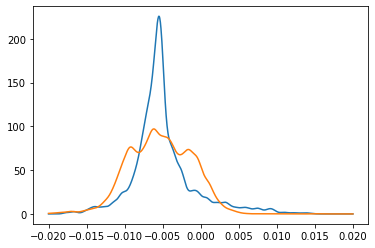

In [283]:
X = np.linspace(-.02, .02, 1000)
plt.plot(X, density(X, vel.flatten()[en_glaciar.flatten()], sigma_scale=.1))
plt.plot(X, density(X, vel.flatten(), sigma_scale=.1))